## Death-Slot analysis - 2nd draw position Finals

In [1]:
import pandas as pd, numpy as np, seaborn as sbn, matplotlib.pyplot as plt

from Modules import utils as utl
from Modules import data_exploration as de
from Modules import machine_learning as ml

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import sklearn.metrics as sm

In [3]:
from scipy.stats import zscore
from scipy.stats import ttest_ind

#### Load cleaned CSV file and verify/ensure numeric draw positions

In [7]:
csv_finals_path = 'Data/finalists_cleaned.csv'

In [9]:
finals_df = utl.load_csv(csv_finals_path, skiprows=0, encoding='windows-1252')

In [11]:
# Identify null values. So long as we don't find any in final_place, final_draw_position or year, we can continue without further data cleaning
finals_df.isna().sum()

year                       0
final_draw_position        0
country                    0
style                      0
final_televote_points     32
final_jury_points         32
final_televote_votes     128
final_jury_votes         128
final_place                0
final_total_points         0
dtype: int64

In [19]:
# Quick check to see if the 3 features we need are in fact numeric
finals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   358 non-null    int64  
 1   final_draw_position    358 non-null    int64  
 2   country                358 non-null    object 
 3   style                  358 non-null    object 
 4   final_televote_points  326 non-null    float64
 5   final_jury_points      326 non-null    float64
 6   final_televote_votes   230 non-null    float64
 7   final_jury_votes       230 non-null    float64
 8   final_place            358 non-null    float64
 9   final_total_points     358 non-null    float64
dtypes: float64(6), int64(2), object(2)
memory usage: 28.1+ KB


#### EDA (Exploratory Data Analysis) - Does position 2 stand out?

In [21]:
# Filter out the 27th draw position (only in 2015 - Italy)
# It would have negatively impacted our analysis
finals_df = finals_df[finals_df['final_draw_position'] <= 26]

In [23]:
# Group draw position and final place and calculate count, mean, median and standard variation for all draw positions
draw_position_stats_finals = finals_df.groupby('final_draw_position')['final_place'].agg(['count', 'mean', 'median', 'std']).sort_index()

In [25]:
# See the results but only for draw position 2
draw_position_stats_finals.loc[2]

count     14.000000
mean      19.500000
median    21.500000
std        5.229355
Name: 2, dtype: float64

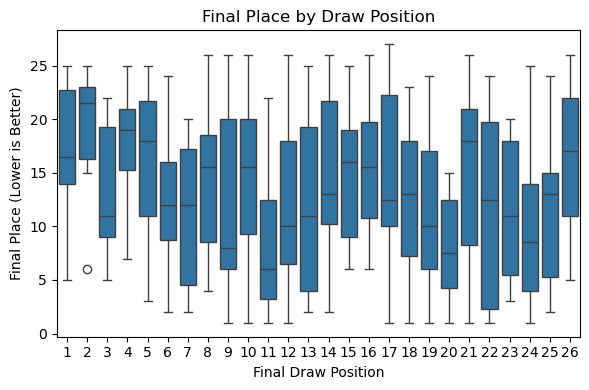

In [29]:
# Create a boxplot to see if there are any outliers and visualize our data
de.vs.boxplot(data=finals_df, x='final_draw_position', y='final_place', title='Final Place by Draw Position', 
              xlabel='Final Draw Position', ylabel='Final Place (Lower is Better)')

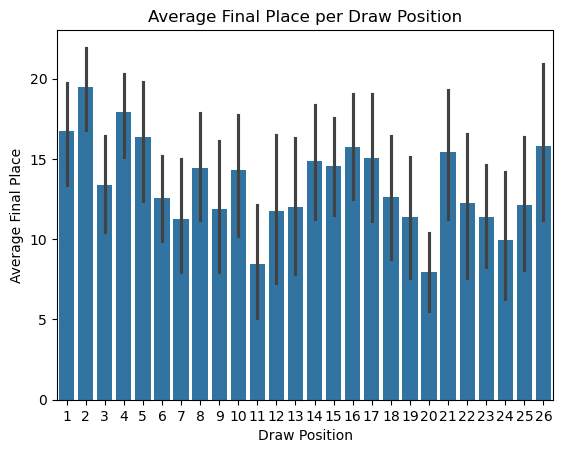

In [31]:
# Create a barplot to visualize overall performance of each position as well as the standard error
de.vs.barplot(finals_df, x_col='final_draw_position', y_col='final_place', agg_func='mean', 
              title='Average Final Place per Draw Position', 
              xlabel='Draw Position', ylabel='Average Final Place')

##### Important note: A year had 27 finalists, we will ignore the 27th draw position as not enough data exists to correctly analyse this.

##### From our draw position stats and our boxplot and barplot we now see the following:
- From 2009 to 2023 we correctly found 14 entries that performed in the 2nd draw position in the Eurovision finals.
- On average these entries placed 19.5 (mean), so around the 19th or 20th place, at the finals - which is not great.
- The median at 21.5, the middle-ranked entry after sorting, placed 21.5th - which, given that it's worse than the mean, suggests that entries performing at the 2nd draw position skew towards bad results.
- The STD (standard deviation) at 5.229 explains that most entries place within ±5 places of the mean (so roughly between 14th and 25th place)

The boxplot shows that the interquartile range (middle 50% of data) goes from roughly 16th to 23rd place. The median is correctly placed at 21.5 The whiskers are fairly narrow suggesting the data, outliers excluded, has limited range. And we have only 1 outlier at the 6th place, which is the best performance an entry at the 2nd draw position has achieved in the 2009-2023 timespan.
The box for 2nd position itself is the second smallest one suggesting low variability in performance, while also being the most upward box - so far confirming our hypothesis that the Death-Slot is a real thing. Other draw positions have similarly high medians, with greater variability but none quite as profound as the 2nd draw position.

The barplot shows us the overall performance of each draw position, and it's clear that 2nd position has had the worst (mean/average) performance with a fairly low standard error. At the same time we see that draw positions 11 and 20 appear to be the, on average, best performing draw positions. 

#### Attempt at testing our hypothesis and use z-scores to see if position 2 is itself an outlier in performance

In [33]:
# Extracts the mean values for each draw position from our previous calculation
# Calculates the z_scores of the mean values
# Filters z-scores to only include those for draw position 2 (just incase we need that one)
draw_position_means_finals = draw_position_stats_finals['mean']
z_scores_finals = zscore(draw_position_means_finals)
position_2_z_finals = z_scores_finals[draw_position_stats_finals.index == 2]

In [35]:
z_scores_finals

final_draw_position
1     1.205798
2     2.232732
3    -0.031789
4     1.653436
5     1.074140
6    -0.321437
7    -0.795407
8     0.363185
9    -0.584754
10    0.310522
11   -1.848672
12   -0.624251
13   -0.532090
14    0.521175
15    0.415849
16    0.837155
17    0.600170
18   -0.295106
19   -0.769075
20   -2.032994
21    0.731828
22   -0.426764
23   -0.769075
24   -1.295708
25   -0.479427
26    0.860561
Name: mean, dtype: float64

##### Computing z-scores of the mean final place for each draw position to see if 2 is "extreme"/stands out.
With 2nd draw position having a z-score of 2.232 it means that the average final place of entries starting at position 2 are over 2 standrad deviations worse than the overall average of all positions.
With 1.96 typically being enough to be considered statistically "extreme", we have exceeded this number. This means we can technically say that 2nd draw position is an outlier by itself, it is clear that we have a strong indicator that Position 2 has one of the worst average placements. No other draw positions has a higher z-score than position 2. Interestingly, we do see that position 20 has a z-score of -2.032 also making it an outlier in itself but as being possible the best draw position to have.

In [39]:
# Extracts all final place values from the rows where draw position = 2
# Extracts all final place values from rows where draw position is != 2
position_2_finals = finals_df[finals_df['final_draw_position'] == 2]['final_place']
other_positions_finals = finals_df[finals_df['final_draw_position'] != 2]['final_place']

In [41]:
# A 2 sample t-test (final place for position 2 - sample1, final place for all other positions - sample2)
# equal_var=False means we are doing a Welch's t-test. Taking into account that sample2 is larger than sample1, and that variability might differ
# t_stat is a measure of the difference between sample means relative to variance
# p_val is the probability that any observed differences are simply due to chance/randomness
t_stat, p_val = ttest_ind(position_2_finals, other_positions_finals, equal_var=False)
print(f"T-statistic: {t_stat}, p-value: {p_val}")

T-statistic: 4.353512969164997, p-value: 0.000550637939526269


##### T-Test of position 2 against all others
Using Welch's t-test, comparing position 2 versus all other draw positions, we get a p-value of just 0.0005 and a t-statistic of 4.353. 
The t-statistic indicates that the difference between the mean final placements of these two groups is approx. 4.4 standard errors apart, which is strong evidence of a meaningful difference. 
Our result when comparing position 2 to all other positions combined, is that we observe significantly worse average placement for postion 2. This must be taken with a slight grain of salt however as we are comparing entries at position 2 with entries from all other positions - creating an imbalance as we do know other draw positions have similar, if not as profound, disadvantages. However, this score is still significant enough that even compared against a field of positions, that we can say it is a worse draw position.

The p-value is very low. Our hypothesis being that starting at 2nd draw position aka the Death-Slot is signifanctly worse than any other draw position, this means our null hypothesis is that there is no difference. If the p-value is smaller than 0.05 that's ordinarily enough to reject the null hypothesis. Ours is much lower at just 0.0005, meaning that it is highly unlikely that entries starting at the 2nd draw position have performed badly by mere chance alone - strongly suggesting that the 2nd position does in fact performe statistically worse. 

#### Outlier free - without the song that started at draw position 2 and finished in 6th place.

In [46]:
# Creates a new dataframe with only data for draw postion 2
# Removes outliers with IQR from the dataframe and saves clean version
position_df = finals_df[finals_df['final_draw_position'] == 2].copy()
finals_df_no_outliers = de.dp.remove_outliers_fix(position_df, position_df['final_place'])

In [48]:
# Creates a dataframe with no outliers on draw position 2 by replacing all draw position 2 rows in finals_df with those in df_no_outliers
# All other rows remain original
finals_no_outliers = pd.concat([
    finals_df[finals_df['final_draw_position'] != 2],
    finals_df_no_outliers
], ignore_index=True)

In [50]:
# Repeat: Group draw position and final place and calculate count, mean, median and standard variation for all draw positions
draw_position_stats_finals_clean = finals_no_outliers.groupby('final_draw_position')['final_place'].agg(['count', 'mean', 'median', 'std']).sort_index()

In [52]:
draw_position_stats_finals_clean.loc[2]

count     13.000000
mean      20.538462
median    22.000000
std        3.642696
Name: 2, dtype: float64

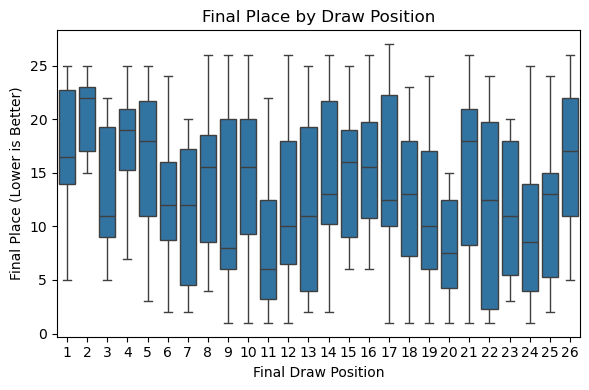

In [54]:
# Create a boxplot to visualize our data, outlier free
de.vs.boxplot(data=finals_no_outliers, x='final_draw_position', y='final_place', title='Final Place by Draw Position', 
              xlabel='Final Draw Position', ylabel='Final Place (Lower is Better)')

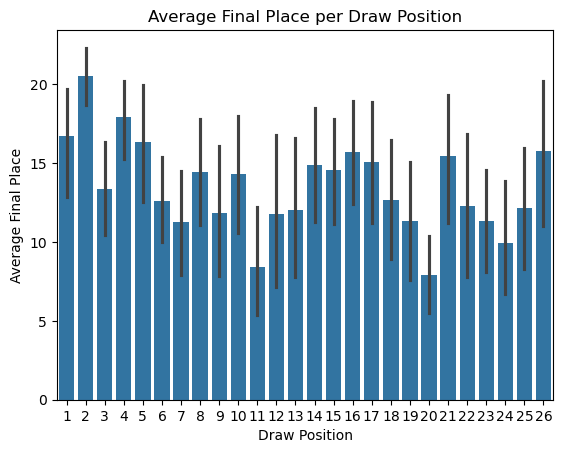

In [56]:
# Create a barplot to visualize overall performance of each position as well as the standard error, not affected by outlier
de.vs.barplot(finals_no_outliers, x_col='final_draw_position', y_col='final_place', agg_func='mean', 
              title='Average Final Place per Draw Position', 
              xlabel='Draw Position', ylabel='Average Final Place')

##### New draw position stats and our outlier free boxplot and barplot we see the following:
- With the outlier removed, from 2009 to 2023 we have 13 entries that performed in the 2nd draw position in the Eurovision finals.
- On new average of these entries placed 20.53 (mean), so around the 20th or 21st place, at the finals - which is not great, and worse than before.
- The new median at 22, the middle-ranked entry, placed 22nd - which, given that it's worse than the mean, suggests that entries performing at the 2nd draw position still skew towards bad results.
- The updated STD (standard deviation) at 3.642 explains that most entries place within ±3.6 places of the mean (so roughly between 17th and 24th place)

The boxplot shows that the new interquartile range (middle 50% of data) goes from roughly 17th to 23rd place. The median is correctly placed at 22. The whiskers are still fairly narrow suggesting the data has limited range.
The box for 2nd position itself is the second smallest one suggesting low variability in performance, while also being the most upward box - so far confirming our hypothesis that the Death-Slot is a real thing. Other draw positions have similarly high medians, with greater variability but none quite as profound as the 2nd draw position.

The barplot shows us the overall performance of each draw position, and it's clear that 2nd position has had the worst (mean/average) performance with a fairly low standard error. At the same time we see that draw positions 11 and 20 appear to be the, on average, best performing draw positions.

#### Testing our hypothesis with the outlier free dataframe

In [58]:
# Repeats our z-score calculation without the big outlier
draw_position_means_finals_clean = draw_position_stats_finals_clean['mean']
z_scores_finals_clean = zscore(draw_position_means_finals_clean)
position_2_z_finals_clean = z_scores_finals_clean[draw_position_stats_finals_clean.index == 2]

In [60]:
z_scores_finals_clean

final_draw_position
1     1.150826
2     2.512945
3    -0.044941
4     1.583338
5     1.023617
6    -0.324802
7    -0.782756
8     0.336687
9    -0.579221
10    0.285803
11   -1.800430
12   -0.617383
13   -0.528337
14    0.489338
15    0.387570
16    0.794640
17    0.565663
18   -0.299360
19   -0.757314
20   -1.978523
21    0.692873
22   -0.426569
23   -0.757314
24   -1.266151
25   -0.477453
26    0.817255
Name: mean, dtype: float64

##### Computing z-scores of the mean final place for each draw position to see if 2 is "extreme"/stands out.
The new 2nd draw position z-score of 2.512 means that the average final place of entries starting at position 2 are over 2.5 standrad deviations worse than the overall average of all positions.
Position 2 remains an outlier while position 20 does as well.

In [62]:
position_2_finals_clean = finals_no_outliers[finals_no_outliers['final_draw_position'] == 2]['final_place']
other_positions_finals_clean = finals_no_outliers[finals_no_outliers['final_draw_position'] != 2]['final_place']

In [64]:
# Repeating our t-test to see if t_stat has changed (hgher = stronger evidence our hypothesis is right)
# p_val: If p-value gets lower or remains small we can better rule out that our results are just due to chance
t_stat, p_val = ttest_ind(position_2_finals_clean, other_positions_finals_clean, equal_var=False)
print(f"T-statistic: {t_stat:.10f}, p-value: {p_val:.10f}")

T-statistic: 6.7808478918, p-value: 0.0000043724


##### New T-Test of position 2 against all others
Using Welch's t-test again, comparing position 2 versus all other draw positions, we get a new smaller p-value of 0.000004 and a t-statistic of 6.78. 
The t-statistic indicates that the difference between the mean final placements of these two groups is approx. 6.8 standard errors apart, which is strong evidence of a meaningful difference. 
Our result when comparing position 2 to all other positions combined, is that we observe significantly worse average placement for postion 2. This must be taken with a slight grain of salt however as we are comparing entries at position 2 with entries from all other positions - creating an imbalance as we do know other draw positions have similar, if not as profound, disadvantages. However, this score is still significant enough that even compared against a field of positions, that we can say it is a worse draw position.

The new p-value is even lower. Our hypothesis being that starting at 2nd draw position aka the Death-Slot is signifanctly worse than any other draw position, this means our null hypothesis is that there is no difference. If the p-value is smaller than 0.05 that's ordinarily enough to reject the null hypothesis. At just 0.000004 we can easily reject the null hypothesis again - strongly suggesting that the 2nd position does in fact perform statistically worse. 
Our original hypothesis — that position 2 performs significantly worse — is well supported here.